# Analyze E8 for DELL


Known VCPs for my DELL U4323QE:

- 60 (standard) primary source
- E8 (custom) secondary sources
- E9 (custom) PBP/PIP mode

The code below is meant to analyze E8. I think E9 is just enumerated, no idea if there's a rule. 60 is very easy to get manually - there are only 5 possibilities.

| Input | VCP 60 |
| ----- | ------ |
| USBC  | 0x1b   |
| HDMI1 | 0x11   |
| HDMI2 | 0x12   |
| DP1   | 0x0f   |
| DP2   | 0x13   |

| PxP mode                   | VCP E9  |
| -------------------------- | ------- |
| PIP with lower left insert | x00 x21 |
| PBP two horizontal windows | x00 x2f |
| PBP two vertical windows   | x00 x24 |
| PBP two by two             | x00 x41 |
| PBP/PIP off                | 0x0     |


To generate E8 use

```python
source_values = {
            HDMI1: 0x11,
            HDMI2: 0x12,
            DP1: 0x0F,
            DP2: 0x13,
            USBC: 0x1B,
        }
def model(S2, S3, S4):
    a = source_values[S2] << 0
    b = source_values[S3] << 5
    c = source_values[S4] << 10
    return  a ^ b ^ c
```

S2,S3,S4 - are window numbers (as numbered by Dell firmware).


In [93]:
import pandas as pd
from itertools import product

source_values = {
    "HDMI1": 0x11,
    "HDMI2": 0x12,
    "DP1": 0x0F,
    "DP2": 0x13,
    "USBC": 0x1B,
}


def model(*args: str) -> int:
    S2, S3, S4 = args
    a = source_values[S2] << 0
    b = source_values[S3] << 5
    c = source_values[S4] << 10
    return a ^ b ^ c


windows = set(product(source_values.keys(), repeat=3))
windows = list(filter(lambda ws: len(set(ws)) == len(ws), windows))
e8_values = list(map(lambda w: model(*w), windows))

df = pd.DataFrame(windows, columns=["Window 2", "Window 3", "Window 4"])
df["VCP E8"] = df.apply(lambda row: hex(model(*row.values)), axis=1)
df.sort_values(["Window 2", "Window 3", "Window 4"], inplace=True, ignore_index=True)
df

,Window 2,Window 3,Window 4,VCP E8
0,DP1,DP2,HDMI1,0x466f
1,DP1,DP2,HDMI2,0x4a6f
2,DP1,DP2,USBC,0x6e6f
3,DP1,HDMI1,DP2,0x4e2f
4,DP1,HDMI1,HDMI2,0x4a2f
5,DP1,HDMI1,USBC,0x6e2f
6,DP1,HDMI2,DP2,0x4e4f
7,DP1,HDMI2,HDMI1,0x464f
8,DP1,HDMI2,USBC,0x6e4f
9,DP1,USBC,DP2,0x4f6f


In [105]:
windows = set(product(source_values.keys(), repeat=4))
windows = list(filter(lambda ws: len(set(ws[1:4])) == len(ws[1:4]), windows))

df = pd.DataFrame(windows, columns=["Window 1", "Window 2", "Window 3", "Window 4"])
df["VCP E8"] = df.apply(lambda row: hex(model(*row.values[1:4])), axis=1)
df["VCP 60"] = df.apply(lambda row: hex(source_values[row.values[0]]), axis=1)
df.sort_values(
    ["Window 1", "Window 2", "Window 3", "Window 4"], inplace=True, ignore_index=True
)
df

,Window 1,Window 2,Window 3,Window 4,VCP E8,VCP 60
0,DP1,DP1,DP2,HDMI1,0x466f,0xf
1,DP1,DP1,DP2,HDMI2,0x4a6f,0xf
2,DP1,DP1,DP2,USBC,0x6e6f,0xf
3,DP1,DP1,HDMI1,DP2,0x4e2f,0xf
4,DP1,DP1,HDMI1,HDMI2,0x4a2f,0xf
...,...,...,...,...,...,...
295,USBC,USBC,HDMI1,DP2,0x4e3b,0x1b
296,USBC,USBC,HDMI1,HDMI2,0x4a3b,0x1b
297,USBC,USBC,HDMI2,DP1,0x3e5b,0x1b
298,USBC,USBC,HDMI2,DP2,0x4e5b,0x1b


In [110]:
filtered_df = df[(df["Window 1"] == "HDMI1") & (df["Window 2"] == "DP2")]
#filtered_df = df[(df["VCP E8"] == "0x4a33")]

filtered_df

,Window 1,Window 2,Window 3,Window 4,VCP E8,VCP 60
132,HDMI1,DP2,DP1,HDMI1,0x45f3,0x11
133,HDMI1,DP2,DP1,HDMI2,0x49f3,0x11
134,HDMI1,DP2,DP1,USBC,0x6df3,0x11
135,HDMI1,DP2,HDMI1,DP1,0x3e33,0x11
136,HDMI1,DP2,HDMI1,HDMI2,0x4a33,0x11
137,HDMI1,DP2,HDMI1,USBC,0x6e33,0x11
138,HDMI1,DP2,HDMI2,DP1,0x3e53,0x11
139,HDMI1,DP2,HDMI2,HDMI1,0x4653,0x11
140,HDMI1,DP2,HDMI2,USBC,0x6e53,0x11
141,HDMI1,DP2,USBC,DP1,0x3f73,0x11


# Data prep


In [3]:
import pandas as pd
import numpy as np
#  Przygotowanie danych
# Zastąp przykładowe dane rzeczywistymi danymi systemu
# Każdy ręcznie wprowadzony rekord to (S1, S2, S3, S4, Output)

NONE = 0
HDMI1 = 1
HDMI2 = 2
DP1 = 3
DP2 = 4
USBC = 5

data = [
    (DP2, DP1, DP1, DP1, 0x3DEF),
    (DP2, HDMI1, DP1, DP1, 0x3DF1),
    (DP2, HDMI2, DP1, DP1, 0x3DF2),
    #  (DP2, HDMI2, NONE, NONE, 0x3DF2),
    (DP2, DP2, DP1, DP1, 0x3DF3),
    # (DP2, DP2, NONE, NONE, 0x3DF3),
    # (HDMI1, DP2, NONE, NONE, 0x3DF3),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (HDMI1, HDMI2, DP2, DP1, 0x3E72),
    (HDMI1, DP2, DP2, DP1, 0x3E73),
    (HDMI1, HDMI2, USBC, DP1, 0x3F72),
    # (HDMI1, DP2, NONE, NONE, 0x3F73),
    (DP2, DP2, USBC, DP1, 0x3F73),
    # (DP2, NONE, NONE, NONE, 0x3F73),
    # (DP2, DP2, NONE, NONE, 0x3F73),
    (HDMI1, USBC, USBC, DP1, 0x3F7B),
    (DP2, USBC, DP1, HDMI1, 0x45FB),
    (DP2, HDMI1, DP1, HDMI2, 0x49F1),
    (DP2, HDMI2, DP1, HDMI2, 0x49F2),
    (DP2, USBC, DP1, HDMI2, 0x49FB),
    (DP2, HDMI1, HDMI1, HDMI2, 0x4A31),
    (DP2, HDMI1, DP2, HDMI2, 0x4A71),
    (DP2, USBC, DP1, DP2, 0x4DFB),
    (DP2, USBC, DP1, USBC, 0x6DFB),
    (HDMI1, DP2, DP2, USBC, 0x6E73),
]

# Tworzymy DataFrame dla lepszej analizy
df = pd.DataFrame(data, columns=["S1", "S2", "S3", "S4", "Output"])

In [ ]:
df[["S2", "S3", "S4", "Output"]]

In [4]:
from sklearn.model_selection import train_test_split

# 2. Podział danych na cechy (X) i etykiety (y)
feature_names = ["S2", "S3", "S4"]
X = df[feature_names]  # Stany wejściowe
y = df["Output"]  # Wyjście (2 bajty)

# 3. Podział danych na zbór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## HistGradientBoostingRegressor


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

# 4. Dopasowanie modelu
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

perm_importance = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42
)

In [ ]:
print("Ważność cech (permutation importance):")
for feature, importance in zip(X.columns, perm_importance.importances_mean):
    print(f"{feature}: {importance:.4f}")


# Tworzenie funkcji predykcyjnej
def predict_output_hist(S1, S2, S3, S4):
    """
    Funkcja predykcyjna dla modelu HistGradientBoostingRegressor.
    :param S1: Wartość stanu S1
    :param S2: Wartość stanu S2
    :param S3: Wartość stanu S3
    :param S4: Wartość stanu S4
    :return: Przewidywane wyjście
    """
    input_data = np.array([[S2, S3, S4]])
    output = model.predict(input_data)
    return int(output[0])  # Konwersja wyniku na liczbę całkowitą


# Testowanie funkcji
example_output = predict_output_hist(0, 0, 1, 0)
print(f"Przewidywane wyjście funkcji predict_output_hist: {hex(example_output)}")

## DecisionTreeClassifier


In [ ]:
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier


#  4. Dopasowanie modelu
# Wykorzystujemy Random Forest do analizy zależności (można zmienić na inny model)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
# 6. Analiza wyników
# Sprawdzamy jakość predykcji (dla uproszczenia rzutujemy wyjścia na int)
accuracy = (np.round(predictions) == y_test).mean()
print(f"Dokładność modelu: {accuracy * 100:.2f}%")

# 7. Analiza znaczenia cech
# Ważności cech (pokazuje, które stany mają największy wpływ na wyjście)
feature_importances = model.feature_importances_
for i, col in enumerate(X.columns):
    print(f"Znaczenie {col}: {feature_importances[i]:.4f}")

exported = export_text(model, feature_names=feature_names)
print(exported)

## RandomForestRegressor


In [147]:
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor


#  4. Dopasowanie modelu
# Wykorzystujemy Random Forest do analizy zależności (można zmienić na inny model)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
from sklearn.tree import export_text, plot_tree

print("Ważność cech w RandomForestRegressor:")
for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Eksportowanie jednego z drzew
single_tree = model.estimators_[0]  # Pierwsze drzewo
print("\nReguły pierwszego drzewa:")
print(export_text(single_tree, feature_names=X.columns.tolist()))

In [ ]:
# Wizualizacja drzewa
plt.figure(figsize=(15, 10))
plot_tree(single_tree, feature_names=X.columns, filled=True)
plt.title("Wizualizacja pierwszego drzewa w RandomForestRegressor")
plt.show()

## CategoricalNB


In [ ]:
from sklearn.naive_bayes import CategoricalNB

#  4. Dopasowanie modelu
model = CategoricalNB()
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
# Priorytety klas
# print("Priorytety klas (class_prior_):")
# for cls, prior in zip(model.classes_, model.class_prior_):
#     print(f"Klasa {cls}: {prior:.4f}")

# Prawdopodobieństwa warunkowe
print("\nPrawdopodobieństwa warunkowe (logarytmy):")
for class_idx, class_probs in enumerate(model.feature_log_prob_):
    print(f"  Klasa {model.classes_[class_idx]}:")
    for feature, log_prob in zip(X.columns, class_probs):
        print(log_prob)
        print(
            f"    {feature}: {np.exp(float(log_prob.item)):.4f}"
        )  # Konwersja na float

## LinearRegression


In [152]:
from sklearn.linear_model import LinearRegression

#  4. Dopasowanie modelu
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
from math import log2

print("Wagi regresji liniowej:")
for feature, coef in zip(X.columns, model.coef_):
    c = log2(abs(int(coef)))
    print(f"{feature}: {c:.4f}")

In [ ]:
2 << 10

## Manual approach


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize



In [38]:
# 4. Funkcja generująca funkcję predykcyjną na podstawie wag
# (0, 5, 10, 0)
def generate_function(w6=0, w7=5, w8=10):
    def model(S2, S3, S4):
        source_values = {
            HDMI1: 0x11,
            HDMI2: 0x12,
            DP1: 0x0F,
            DP2: 0x13,
            USBC: 0x1B,
        }
        a = source_values[S2] << int(abs(w6))
        b = source_values[S3] << int(abs(w7))
        c = source_values[S4] << int(abs(w8))
        return  a ^ b ^ c

    return model


In [41]:
from itertools import product


def grid_search_integer_weights(X, y, n_weights=3, min_weight=2, max_weight=16):
    best_mae = float("inf")
    best_weights = None

    for weights in product(range(min_weight, max_weight + 1), repeat=n_weights):
        model = generate_function(*weights)
        predictions = np.array([model(*row) for row in X.values])
        mae = mean_absolute_error(y, predictions)

        if mae < best_mae:
            best_mae = mae
            best_weights = weights

    return best_weights, best_mae


# Przeszukiwanie
optimized_weights, best_mae = grid_search_integer_weights(
    X_train,
    y_train,
    n_weights=3,
    min_weight=0,
    max_weight=12,
)
print("Najlepsze wagi (int):", optimized_weights)
print(f"Średni błąd absolutny (int): {best_mae:.4f}")

Najlepsze wagi (int): (0, 5, 10)
Średni błąd absolutny (int): 0.0000


In [40]:
# 5. Funkcja celu do optymalizacji wag
def objective_function(weights, X, y):
    model = generate_function(*weights)
    predictions = np.array([model(*row) for row in X.values])
    return mean_absolute_error(y, predictions)


# 6. Optymalizacja wag
initial_weights = [1.0, 2.0, 3.0]  # Początkowe wagi
result = minimize(objective_function, initial_weights, args=(X, y), method="BFGS")
optimized_weights = result.x
print("Optymalizowane wagi:", optimized_weights)

# 7. Testowanie funkcji predykcyjnej z optymalizowanymi wagami
optimized_model = generate_function(*optimized_weights)
predicted_outputs = np.array([optimized_model(*row) for row in X_test.values])
mae = mean_absolute_error(y_test, predicted_outputs)
print(f"Średni błąd absolutny dla optymalizowanych wag: {mae:.4f}")

Optymalizowane wagi: [1. 2. 3.]
Średni błąd absolutny dla optymalizowanych wag: 17015.4000


Średni błąd absolutny dla optymalizowanych wag: 0.0000
Optymalizowane wagi: (0, 5, 10)


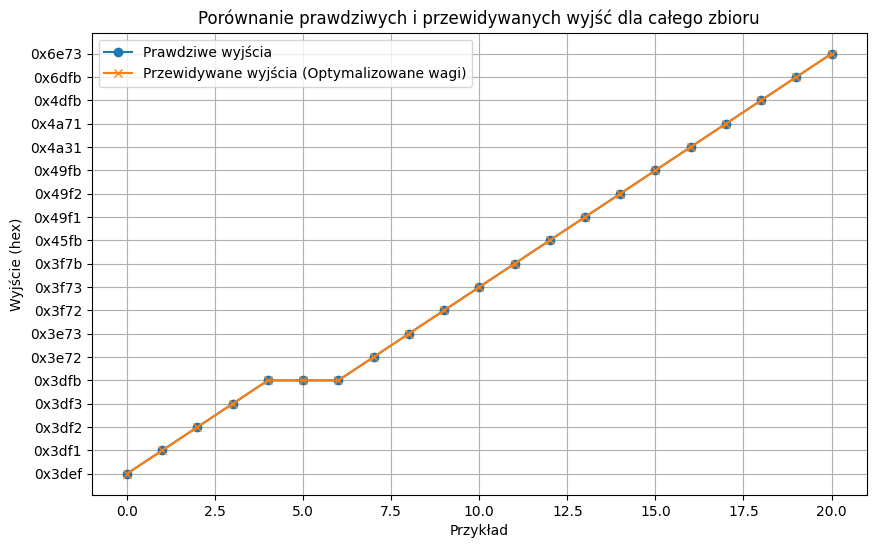

In [42]:

# 7. Testowanie funkcji predykcyjnej z optymalizowanymi wagami
optimized_model = generate_function(*optimized_weights)
predicted_outputs = np.array([optimized_model(*row) for row in X_test.values])
mae = mean_absolute_error(y_test, predicted_outputs)
print(f"Średni błąd absolutny dla optymalizowanych wag: {mae:.4f}")
print("Optymalizowane wagi:", optimized_weights)

# 8.1 Generowanie predykcji dla całego zbioru danych
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = np.array([optimized_model(*row) for row in all_inputs])


# 8.2 Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(all_true_outputs)),
    [f"{int(val):#06x}" for val in all_true_outputs],
    label="Prawdziwe wyjścia",
    marker="o",
)
plt.plot(
    range(len(all_predicted_outputs)),
    [f"{int(val):#06x}" for val in all_predicted_outputs],
    label="Przewidywane wyjścia (Optymalizowane wagi)",
    marker="x",
)
plt.title("Porównanie prawdziwych i przewidywanych wyjść dla całego zbioru")
plt.xlabel("Przykład")
plt.ylabel("Wyjście (hex)")
plt.legend()
plt.grid()
plt.show()

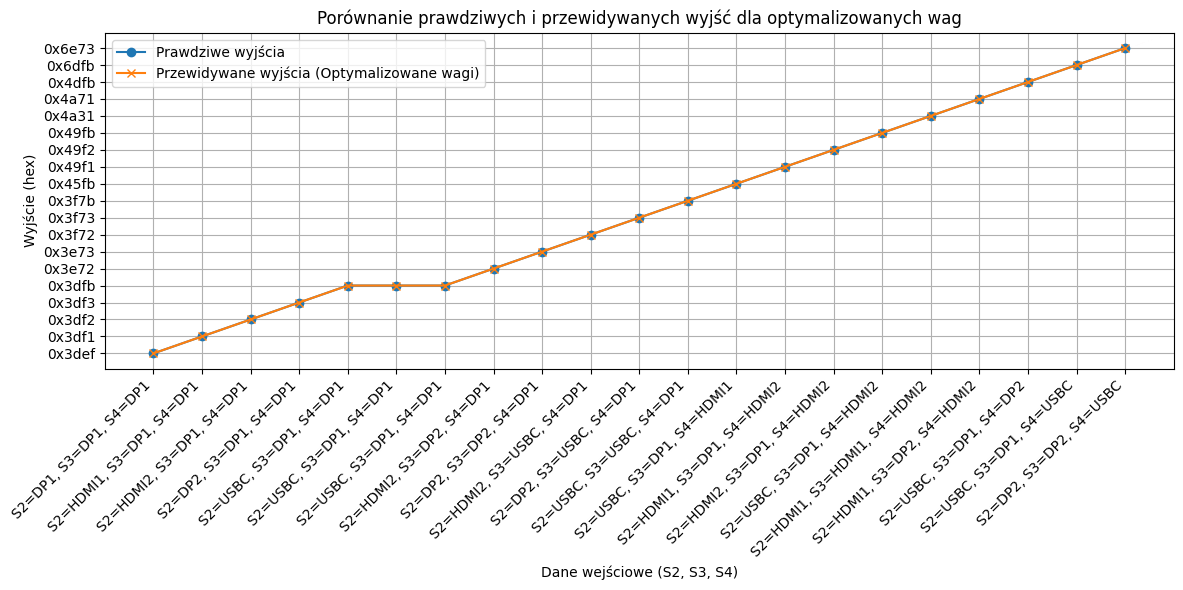

In [43]:
x_labels = [f"S2={row[0]}, S3={row[1]}, S4={row[2]}" for row in X.values]
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y)),
    [f"{int(val):#06x}" for val in y.values],
    label="Prawdziwe wyjścia",
    marker="o",
)
plt.plot(
    range(len(all_predicted_outputs)),
    [f"{int(val):#06x}" for val in all_predicted_outputs],
    label="Przewidywane wyjścia (Optymalizowane wagi)",
    marker="x",
)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha="right")
plt.title("Porównanie prawdziwych i przewidywanych wyjść dla optymalizowanych wag")
plt.xlabel("Dane wejściowe (S2, S3, S4)")
plt.ylabel("Wyjście (hex)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [44]:
# Łączenie tablic w DataFrame
combined_df = pd.DataFrame({
    "S2": X.values[:, 0],
    "S3": X.values[:, 1],
    "S4": X.values[:, 2],
    "Prawdziwe wyjścia": y.values,
    "Przewidywane wyjścia": all_predicted_outputs,
    "Error": all_predicted_outputs-y.values,
})

combined_df

,S2,S3,S4,Prawdziwe wyjścia,Przewidywane wyjścia,Error
0,DP1,DP1,DP1,15855,15855,0
1,HDMI1,DP1,DP1,15857,15857,0
2,HDMI2,DP1,DP1,15858,15858,0
3,DP2,DP1,DP1,15859,15859,0
4,USBC,DP1,DP1,15867,15867,0
5,USBC,DP1,DP1,15867,15867,0
6,USBC,DP1,DP1,15867,15867,0
7,HDMI2,DP2,DP1,15986,15986,0
8,DP2,DP2,DP1,15987,15987,0
9,HDMI2,USBC,DP1,16242,16242,0


## Visuals


In [ ]:
# 9. Opcjonalne: Wizualizacja wyników
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel("Rzeczywiste wyjścia")
plt.ylabel("Przewidywane wyjścia")
plt.title("Porównanie rzeczywistych i przewidywanych wyjść")
plt.show()

In [ ]:
# 8. Eksport wyników i interpretacja
# Wyniki mogą zostać zapisane do pliku CSV dla dalszej analizy
df_results = pd.DataFrame({"Actual": y_test, "Predicted": np.round(predictions)})
df_results
# df_results.to_csv("results.csv", index=False)

# Attempt at model choice


In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# 4. Funkcja do porównywania modeli
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
        "RandomForestRegressor": RandomForestRegressor(random_state=42),
        "CategoricalNB": CategoricalNB(),
        "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42),
    }

    results = {}

    for name, model in models.items():
        try:
            # Dopasowanie modelu
            model.fit(X_train, y_train)
            # Predykcja
            predictions = model.predict(X_test)
            # Ocena
            mae = mean_absolute_error(y_test, predictions)
            results[name] = mae
        except Exception as e:
            results[name] = f"Error: {e}"

    return results


# 5. Porównanie modeli
results = compare_models(X_train, X_test, y_train, y_test)
for model_name, score in results.items():
    print(f"{model_name}: {score}")

# Test output function


In [ ]:
# 7. Tworzenie funkcji predykcyjnej
def predict_output_model(S2, S3, S4):
    input_data = np.array([[S2, S3, S4]])
    output = model.predict(input_data)
    return int(output[0])  # Konwersja wyniku na liczbę całkowitą


predict_output = predict_output_model

# 8. Testowanie funkcji generującej na wszystkich inputach i wizualizacja
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = [predict_output(*row) for row in all_inputs]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(all_true_outputs, label="Prawdziwe wyjścia", marker="o")
plt.plot(all_predicted_outputs, label="Przewidywane wyjścia", marker="x")
plt.title("Porównanie prawdziwych i przewidywanych wyjść")
plt.xlabel("Przykład")
plt.ylabel("Wyjście")
plt.legend()
plt.grid()
plt.show()